In [4]:
import os
import imageio
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline
tf.__version__

'1.15.2'

In [5]:
#loading pretrained model VGG
pp = pprint.PrettyPrinter(indent=4)
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")
pp.pprint(model)

{   'avgpool1': <tf.Tensor 'AvgPool_10:0' shape=(1, 150, 200, 64) dtype=float32>,
    'avgpool2': <tf.Tensor 'AvgPool_11:0' shape=(1, 75, 100, 128) dtype=float32>,
    'avgpool3': <tf.Tensor 'AvgPool_12:0' shape=(1, 38, 50, 256) dtype=float32>,
    'avgpool4': <tf.Tensor 'AvgPool_13:0' shape=(1, 19, 25, 512) dtype=float32>,
    'avgpool5': <tf.Tensor 'AvgPool_14:0' shape=(1, 10, 13, 512) dtype=float32>,
    'conv1_1': <tf.Tensor 'Relu_32:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv1_2': <tf.Tensor 'Relu_33:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv2_1': <tf.Tensor 'Relu_34:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv2_2': <tf.Tensor 'Relu_35:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv3_1': <tf.Tensor 'Relu_36:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_2': <tf.Tensor 'Relu_37:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_3': <tf.Tensor 'Relu_38:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_4': <tf.Tensor 'Relu_39:0' shape=(

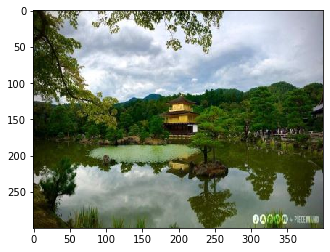

In [6]:
#content image
content_image = imageio.imread("japanese_garden.jpg")
imshow(content_image);

In [11]:
#computing Content cost
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G 
    a_C_unrolled = tf.reshape(a_C, shape=[m,n_H*n_W,n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m,n_H*n_W,n_C])
    
    # compute the cost with tensorflow 
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled)))/(4*n_H*n_W*n_C)
    
    return tf.cast(J_content, tf.float32)

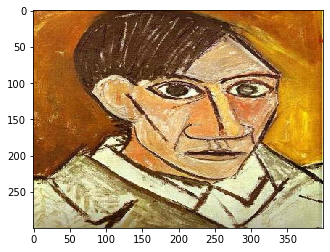

In [12]:
#Style image
style_image = imageio.imread("picasso_selfportrait.jpg")
imshow(style_image);

In [13]:
#gram matrix - computing style of the image
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    GA = tf.matmul(A,tf.transpose(A))
    return GA

In [14]:
# style cost for a layer
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieve dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) 
    a_S = tf.reshape(tf.transpose(a_S), shape=[n_C,n_H*n_W])
    a_G = tf.reshape(tf.transpose(a_G), shape=[n_C,n_H*n_W])

    # Computing gram_matrices for both images S and G 
    GS = tf.cast(gram_matrix(a_S),tf.float32)
    GG = tf.cast(gram_matrix(a_G),tf.float32)

    # Computing the loss 
    J_style_layer = (tf.reduce_sum(tf.square(tf.subtract(GS,GG))))/(4*n_H*n_W*n_C*n_H*n_W*n_C)
    
    return tf.cast(J_style_layer, tf.float32)

In [15]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [16]:
#Total style cost
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [17]:
#total cost
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """

    J = alpha*J_content+beta*J_style
    
    
    return J

In [52]:
# Reset the graph
tf.compat.v1.reset_default_graph()

# Start interactive session
sess=tf.compat.v1.InteractiveSession()

c:\python373\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [53]:
content_image = imageio.imread("japanese_garden.jpg")
content_image = reshape_and_normalize_image(content_image)

In [54]:
style_image = imageio.imread("picasso_selfportrait.jpg")
style_image = reshape_and_normalize_image(style_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


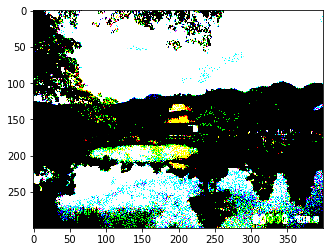

In [55]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0]);

In [56]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

In [57]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [58]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [59]:
J = total_cost(J_content, J_style, alpha = 10, beta = 90)

In [60]:
# define optimizer 
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step 
train_step = optimizer.minimize(J)

In [61]:
def model_nn(sess, input_image, num_iterations = 40):
    
    # Initialize global variables (you need to run the session on the initializer)
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    generated_image=sess.run(model['input'].assign(input_image))
    
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model["input"].assign(generated_image))

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [63]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 21148926000.0
content cost = 8569.164
style cost = 234987120.0
Iteration 20 :
total cost = 21148926000.0
content cost = 8569.164
style cost = 234987120.0


array([[[[-36.09456  , -33.675335 , -31.605545 ],
         [-37.251816 , -47.09303  , -38.790928 ],
         [-34.862873 , -36.712986 , -34.19442  ],
         ...,
         [ 19.814243 ,  17.509624 ,  28.68194  ],
         [  7.7640977,  12.030604 ,  28.75369  ],
         [ 11.0476675,  17.849035 ,  32.221836 ]],

        [[-36.88577  , -26.698772 , -47.300472 ],
         [-31.87463  , -46.444134 , -44.19063  ],
         [-40.111237 , -34.04552  , -31.496458 ],
         ...,
         [ 22.908308 ,  13.339739 ,  15.211378 ],
         [ 15.756808 ,   2.4395332,  25.506342 ],
         [ 13.777197 ,  15.674157 ,  35.515274 ]],

        [[-36.52649  , -16.488277 , -26.22874  ],
         [-24.137947 , -17.899149 , -31.58915  ],
         [-29.082369 , -41.56413  , -37.084534 ],
         ...,
         [  3.1664183,  21.47788  ,  28.182236 ],
         [  1.8325775,  10.1987505,  13.503572 ],
         [  8.872654 ,  23.635647 ,  13.991852 ]],

        ...,

        [[-28.001617 , -30.293936 , -3

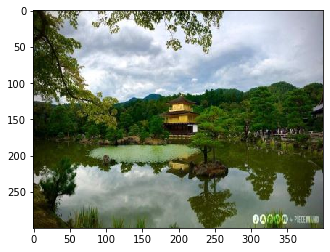

In [65]:
#content image
content_image = imageio.imread("japanese_garden.jpg")
imshow(content_image);

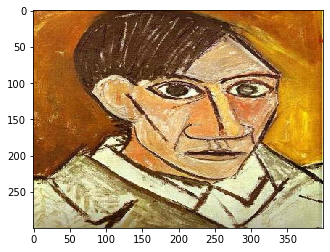

In [66]:
#Style image
style_image = imageio.imread("picasso_selfportrait.jpg")
imshow(style_image);

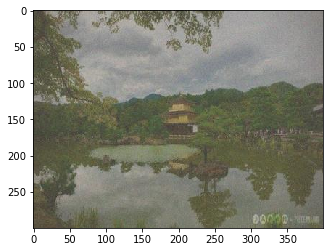

In [67]:
#Generated image
gen_image = imageio.imread("output/generated_image.jpg")
imshow(gen_image);